<h1> Gastric Lymphoma Survival Analysis </h1>

In [1]:
########## R Code: Gastric Lymphoma Survival Analysis
suppressPackageStartupMessages({
library(survival)
library(survminer)
library(dplyr)
library(stringr)
library(lubridate)
    })

In [2]:
# 1. Load Data
# Ensure your CSV has columns like: 'age', 'sex', 'year_diag'
raw_data <- read.csv("data/data.csv")

In [3]:
# 2. Define Tumor Location Groups
# We use the 'Localiz_tumor_r' column from your summary
survival_data <- raw_data %>%
  mutate(
    # Create broad location categories
    Site_Group = case_when(
      str_detect(Localiz_tumor_r, "Estómago") ~ "Gastric",
      str_detect(Localiz_tumor_r, "Ganglios") ~ "Nodal",
      TRUE ~ "Extranodal (Non-Gastric)"
    ),
    Site_Group = factor(Site_Group, levels = c("Nodal", "Gastric", "Extranodal (Non-Gastric)")),

    # Ensure Dates/Time are ready (using the code we fixed earlier)
    Date_Diagnosis = ymd(as.character(Fecha_diag)),
    Date_LastContact = ymd(as.character(Fecha_ultcont)),
    Date_Death = ymd(as.character(Fecha_fall)),
    OS_status = case_when(
      as.character(Estado_vital) == "Fallecido" ~ 1,
      as.character(Estado_vital) == "Vivo" ~ 0,
      TRUE ~ NA_real_
    ),
    End_Date = if_else(OS_status == 1, Date_Death, Date_LastContact),
    OS_time = as.numeric(difftime(End_Date, Date_Diagnosis, units = "days")) / 30.4375
  ) %>%
  filter(!is.na(OS_time), OS_time > 0, !is.na(OS_status))

In [4]:
# 3. Fit Survival Model
fit_site <- survfit(Surv(OS_time, OS_status) ~ Site_Group, data = survival_data)

In [5]:
# 4. Generate Plot
p_site <- ggsurvplot(
  fit_site,
  data = survival_data,
  linewidth = 1,
  palette = c("#2E9FDF", "#E7B800", "#FC4E07"), # Blue, Yellow, Red
  conf.int = FALSE,
  pval = TRUE,
  risk.table = TRUE,
  title = "Survival by Tumor Location (Gastric vs. Nodal)",
  xlab = "Time (Months)",
  legend.labs = c("Nodal", "Gastric", "Other Extranodal"),
  ggtheme = theme_classic(base_size = 14)
)

Warning message:
“Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.
ℹ The deprecated feature was likely used in the ggpubr package.
  Please report the issue at <https://github.com/kassambara/ggpubr/issues>.”


Ignoring unknown labels:
• colour : "Strata"


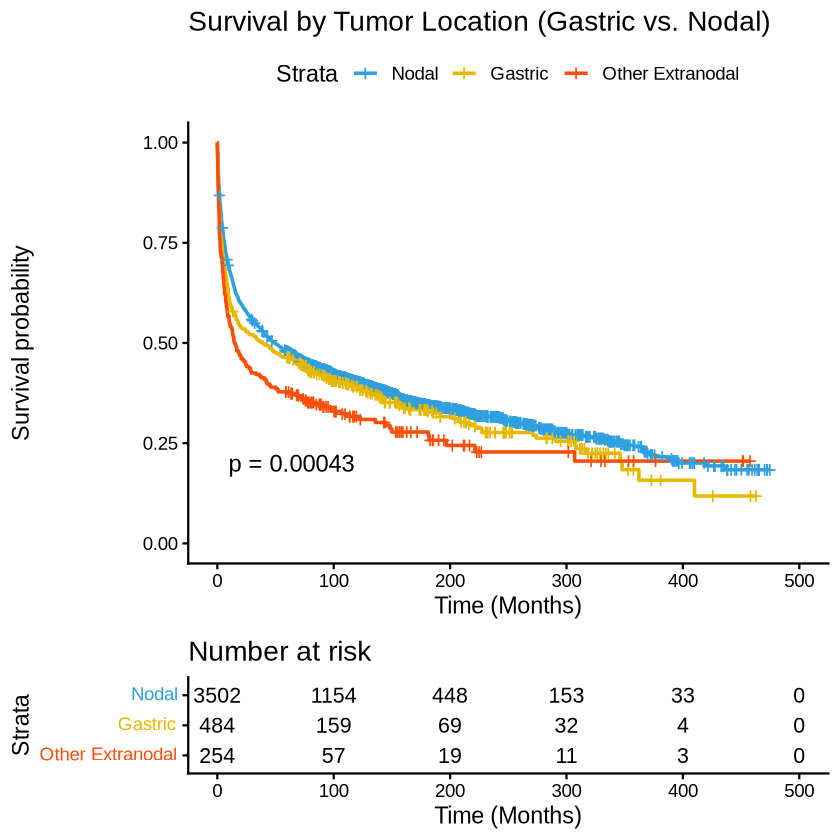

In [6]:
p_site

In [7]:
# --- 5. Generate the Combined Plot ---
p_site <- ggsurvplot(
  fit_site,
  data = survival_data,
  linewidth = 1.1,
  palette = c("#3C5488FF", "#E64B35FF", "#00A087FF"), 
  conf.int = TRUE,           
  pval = "p < 0.001",        # Static label for the p=0.0004 result [cite: 30, 111, 232]
  pval.coord = c(1, 0.1),    # Position p-value away from curves
  risk.table = TRUE,         # This enables the strata numbers
  risk.table.y.text = TRUE,  # Show the group names next to the numbers
  risk.table.fontsize = 3.5, # Size compatible with Arial 10/11
  legend.title = "Site",
  legend.labs = c("Nodal", "Gastric", "Other Extranodal"),
  xlab = "Months from Diagnosis",
  ylab = "Survival Probability",
  # Set the theme for the plot and the risk table
  ggtheme = theme_classic(base_size = 12) + 
            theme(axis.title = element_text(face = "bold"),
                  legend.text = element_text(size = 10)),
  risk.table.col = "strata"   # Color the numbers to match the lines
)



In [8]:
# --- SAVE SUPPLEMENTARY FIGURE S1 ---
# Using the standard 180mm width for double-column publication
# 180mm = 7.08 inches | 160mm = 6.3 inches (height adjusted for risk table)

pdf("images/Supp_Figure_S1_Gastric_Survival.pdf", 
    width = 7.08, 
    height = 6.3, 
    onefile = FALSE) # Prevents blank first page in some Linux viewers

print(p_site)

dev.off()

png 
  2

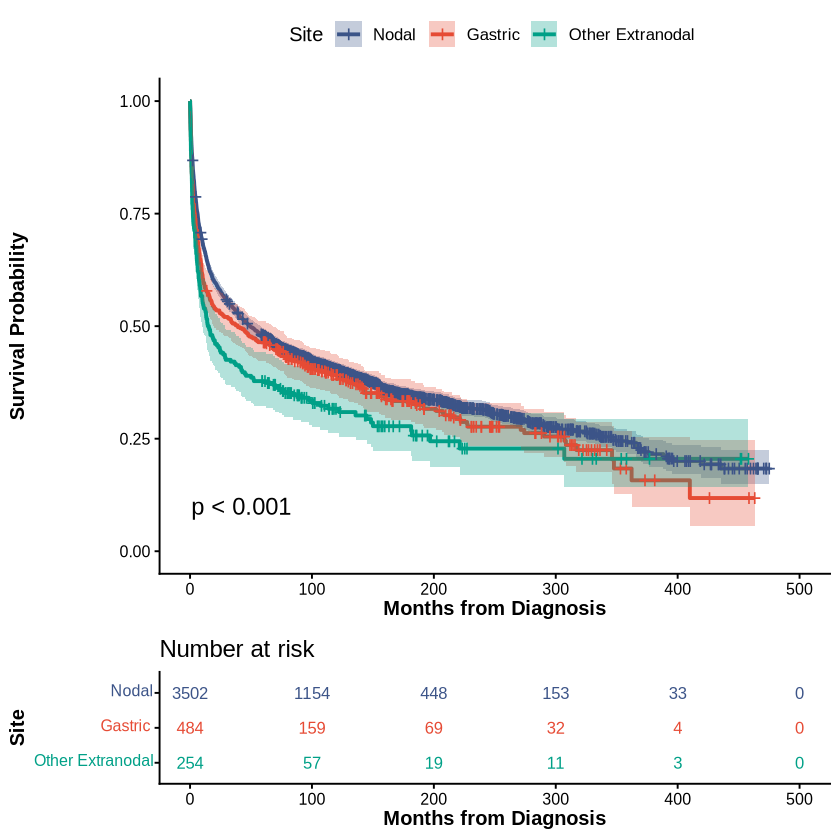

In [9]:
p_site